In [1]:
from model import HRNet_HPE
from customCOCO import CustomCOCO

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import random
from tqdm import tqdm


In [2]:
PATH = '/home/sojeong/CV/resnet/model_hrnet'

train_coco_json_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/annotations/person_keypoints_train2017.json'
train_coco_img_path  = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/train2017/'
test_coco_json_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/annotations/person_keypoints_val2017.json'
test_coco_img_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/val2017'

training_data = CustomCOCO(train_coco_json_path, train_coco_img_path)
#test_data = CustomCOCO(test_coco_json_path, test_coco_img_path)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [3]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

reset_seed(2022)

In [4]:
def train(model, n_epoch, loader, optimizer, criterion, device="cpu"):
    model.train()
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, (images, labels, visibility) in enumerate(tqdm(loader)):
            if i == 1000: break 
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            # print("size of outputs: ", outputs.shape)
            # print("size of labels: ", labels.shape)
            loss = criterion(input=outputs, target=labels)
            loss.mean().backward()
            optimizer.step()
            running_loss += loss.mean().item()

        print('Epoch {}, loss = {:.3f}'.format(epoch, running_loss/len(loader)))
    
    print('Training Finished')

In [12]:
model = HRNet_HPE.PoseHRNet().cuda()
model = model.cuda(0)
if torch.cuda.device_count() > 1:
	  model = nn.DataParallel(model) 
criterion = nn.MSELoss(reduction='none')
optimizer = optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)

## train
train(model=model, n_epoch=3, loader=train_dataloader, optimizer=optimizer, criterion=criterion, device="cuda")
torch.save(model, PATH)


/home/sojeong/anaconda3/envs/cv/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
  6%|▌         | 1000/16405 [10:42<2:44:50,  1.56it/s]


Epoch 0, loss = nan


  6%|▌         | 1000/16405 [10:13<2:37:32,  1.63it/s]


Epoch 1, loss = nan


  6%|▌         | 1000/16405 [09:59<2:33:55,  1.67it/s]


Epoch 2, loss = nan
Training Finished


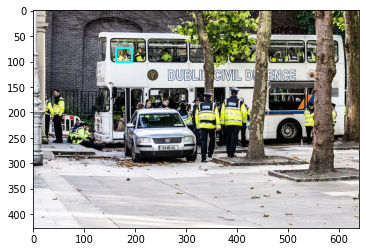

In [13]:
training_data.load_img(10200)
training_data.show_original_bbox()

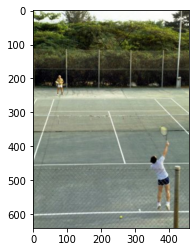

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_path = "/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/train2017/000000410343.jpg"
# Show images
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [15]:
image.shape

(640, 459, 3)

In [16]:
for i, (images, labels, visibility) in enumerate(train_dataloader):
    if i == 1: break 
    images = images.to('cuda')
    labels = labels.to('cuda')
    visibility = visibility.to('cuda')

In [17]:
model(images)[0].shape

torch.Size([17, 64, 48])

In [18]:
def save_batch_image_with_joints(batch_image, batch_joints, batch_joints_vis,
                                 file_name, nrow=8, padding=2):
    '''
    batch_image: [batch_size, channel, height, width]
    batch_joints: [batch_size, num_joints, 3],
    batch_joints_vis: [batch_size, num_joints, 1],
    }
    '''
    grid = torchvision.utils.make_grid(batch_image, nrow, padding, True)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    ndarr = ndarr.copy()

    nmaps = batch_image.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height = int(batch_image.size(2) + padding)
    width = int(batch_image.size(3) + padding)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break
            joints = batch_joints[k]
            joints_vis = batch_joints_vis[k]

            for joint, joint_vis in zip(joints, joints_vis):
                joint[0] = x * width + padding + joint[0]
                joint[1] = y * height + padding + joint[1]
                if joint_vis[0]:
                    cv2.circle(ndarr, (int(joint[0]), int(joint[1])), 2, [255, 0, 0], 2)
            k = k + 1
    cv2.imwrite(file_name, ndarr)


def save_batch_heatmaps(batch_image, batch_heatmaps, file_name,
                        normalize=True):
    '''
    batch_image: [batch_size, channel, height, width]
    batch_heatmaps: ['batch_size, num_joints, height, width]
    file_name: saved file name
    '''
    if normalize:
        batch_image = batch_image.clone()
        min = float(batch_image.min())
        max = float(batch_image.max())

        batch_image.add_(-min).div_(max - min + 1e-5)

    batch_size = batch_heatmaps.size(0)
    num_joints = batch_heatmaps.size(1)
    heatmap_height = batch_heatmaps.size(2)
    heatmap_width = batch_heatmaps.size(3)

    grid_image = np.zeros((batch_size*heatmap_height,
                           (num_joints+1)*heatmap_width,
                           3),
                          dtype=np.uint8)

    preds, maxvals = get_max_preds(batch_heatmaps.detach().cpu().numpy())

    for i in range(batch_size):
        image = batch_image[i].mul(255)\
                              .clamp(0, 255)\
                              .byte()\
                              .permute(1, 2, 0)\
                              .cpu().numpy()
        heatmaps = batch_heatmaps[i].mul(255)\
                                    .clamp(0, 255)\
                                    .byte()\
                                    .cpu().numpy()

        resized_image = cv2.resize(image,
                                   (int(heatmap_width), int(heatmap_height)))

        height_begin = heatmap_height * i
        height_end = heatmap_height * (i + 1)
        for j in range(num_joints):
            cv2.circle(resized_image,
                       (int(preds[i][j][0]), int(preds[i][j][1])),
                       1, [0, 0, 255], 1)
            heatmap = heatmaps[j, :, :]
            colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            masked_image = colored_heatmap*0.7 + resized_image*0.3
            cv2.circle(masked_image,
                       (int(preds[i][j][0]), int(preds[i][j][1])),
                       1, [0, 0, 255], 1)

            width_begin = heatmap_width * (j+1)
            width_end = heatmap_width * (j+2)
            grid_image[height_begin:height_end, width_begin:width_end, :] = \
                masked_image
            # grid_image[height_begin:height_end, width_begin:width_end, :] = \
            #     colored_heatmap*0.7 + resized_image*0.3

        grid_image[height_begin:height_end, 0:heatmap_width, :] = resized_image

    cv2.imwrite(file_name, grid_image)


In [19]:
heatmap = model(images)[0]

In [20]:
image = image[None, :, :, :]

In [21]:
images.shape

torch.Size([16, 3, 256, 192])

In [22]:
labels.shape

torch.Size([16, 17, 64, 48])

In [36]:
visibilities = visibility[:, :, None]
visibilities[0][0]
labels[0][0][0]

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10.])

In [32]:
import torchvision
import math
save_batch_image_with_joints(images, labels, visibilities,'save_img_with_joint.png')

ValueError: only one element tensors can be converted to Python scalars

In [77]:
visibility.shape

torch.Size([16, 17])